In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
from scipy import stats


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [13]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5,outlier_k=.0625)
df.groupby('outliers').agg('count')
df = df.dropna(subset=['calc_sqft','tax_value'])
train, validate, test = w.tvt_split(df)
df.calc_bath_and_bed.isna().sum()
# train.to_csv('data/prepared_zillow.csv')

0

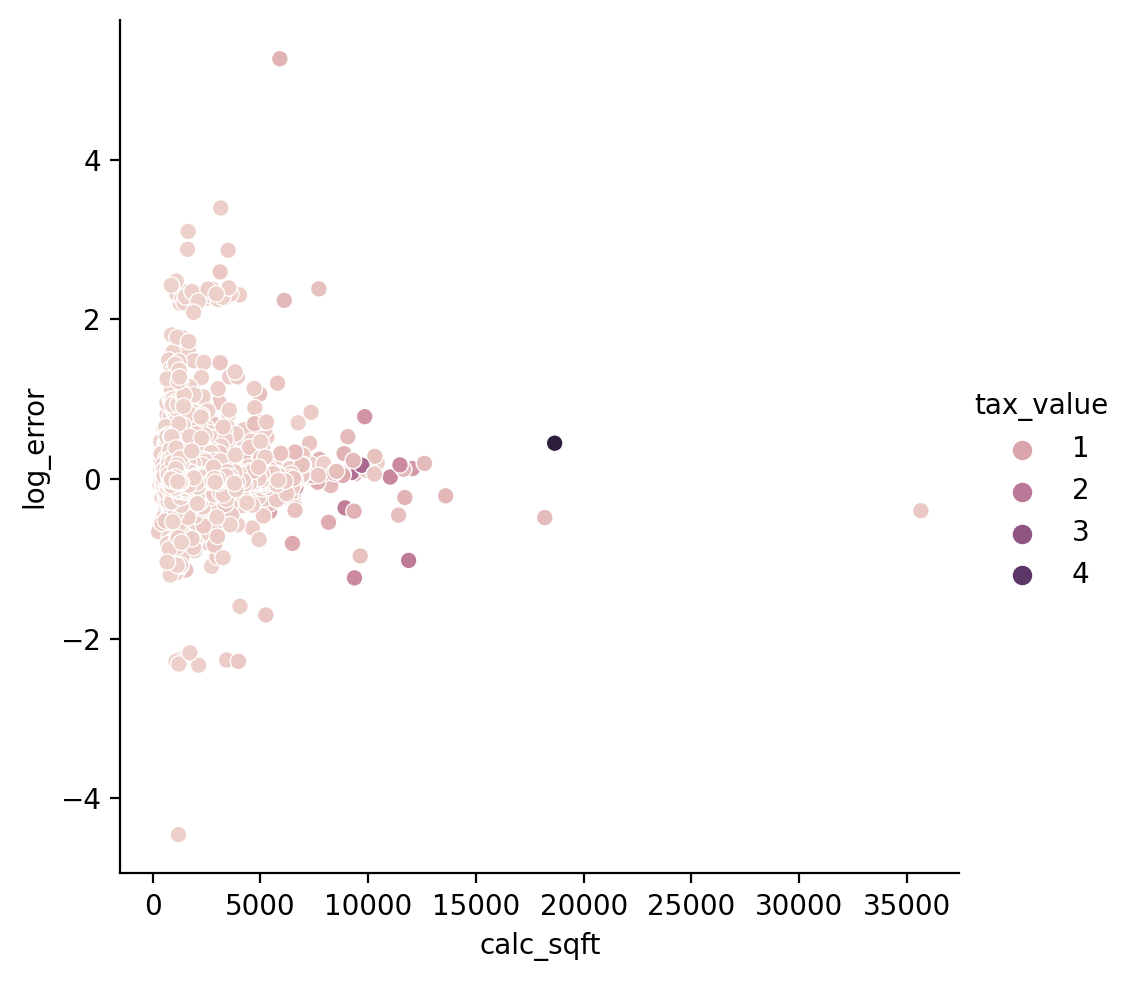

In [ ]:

sns.relplot(data=train.sort_values(by='fips'), x='calc_sqft', y='log_error',hue='tax_value')

In [ ]:
df[['bed_count']]

,bed_count
0,2
1,1
2,3
3,3
4,3
...,...
43217,3
43218,3
43219,4
43220,4


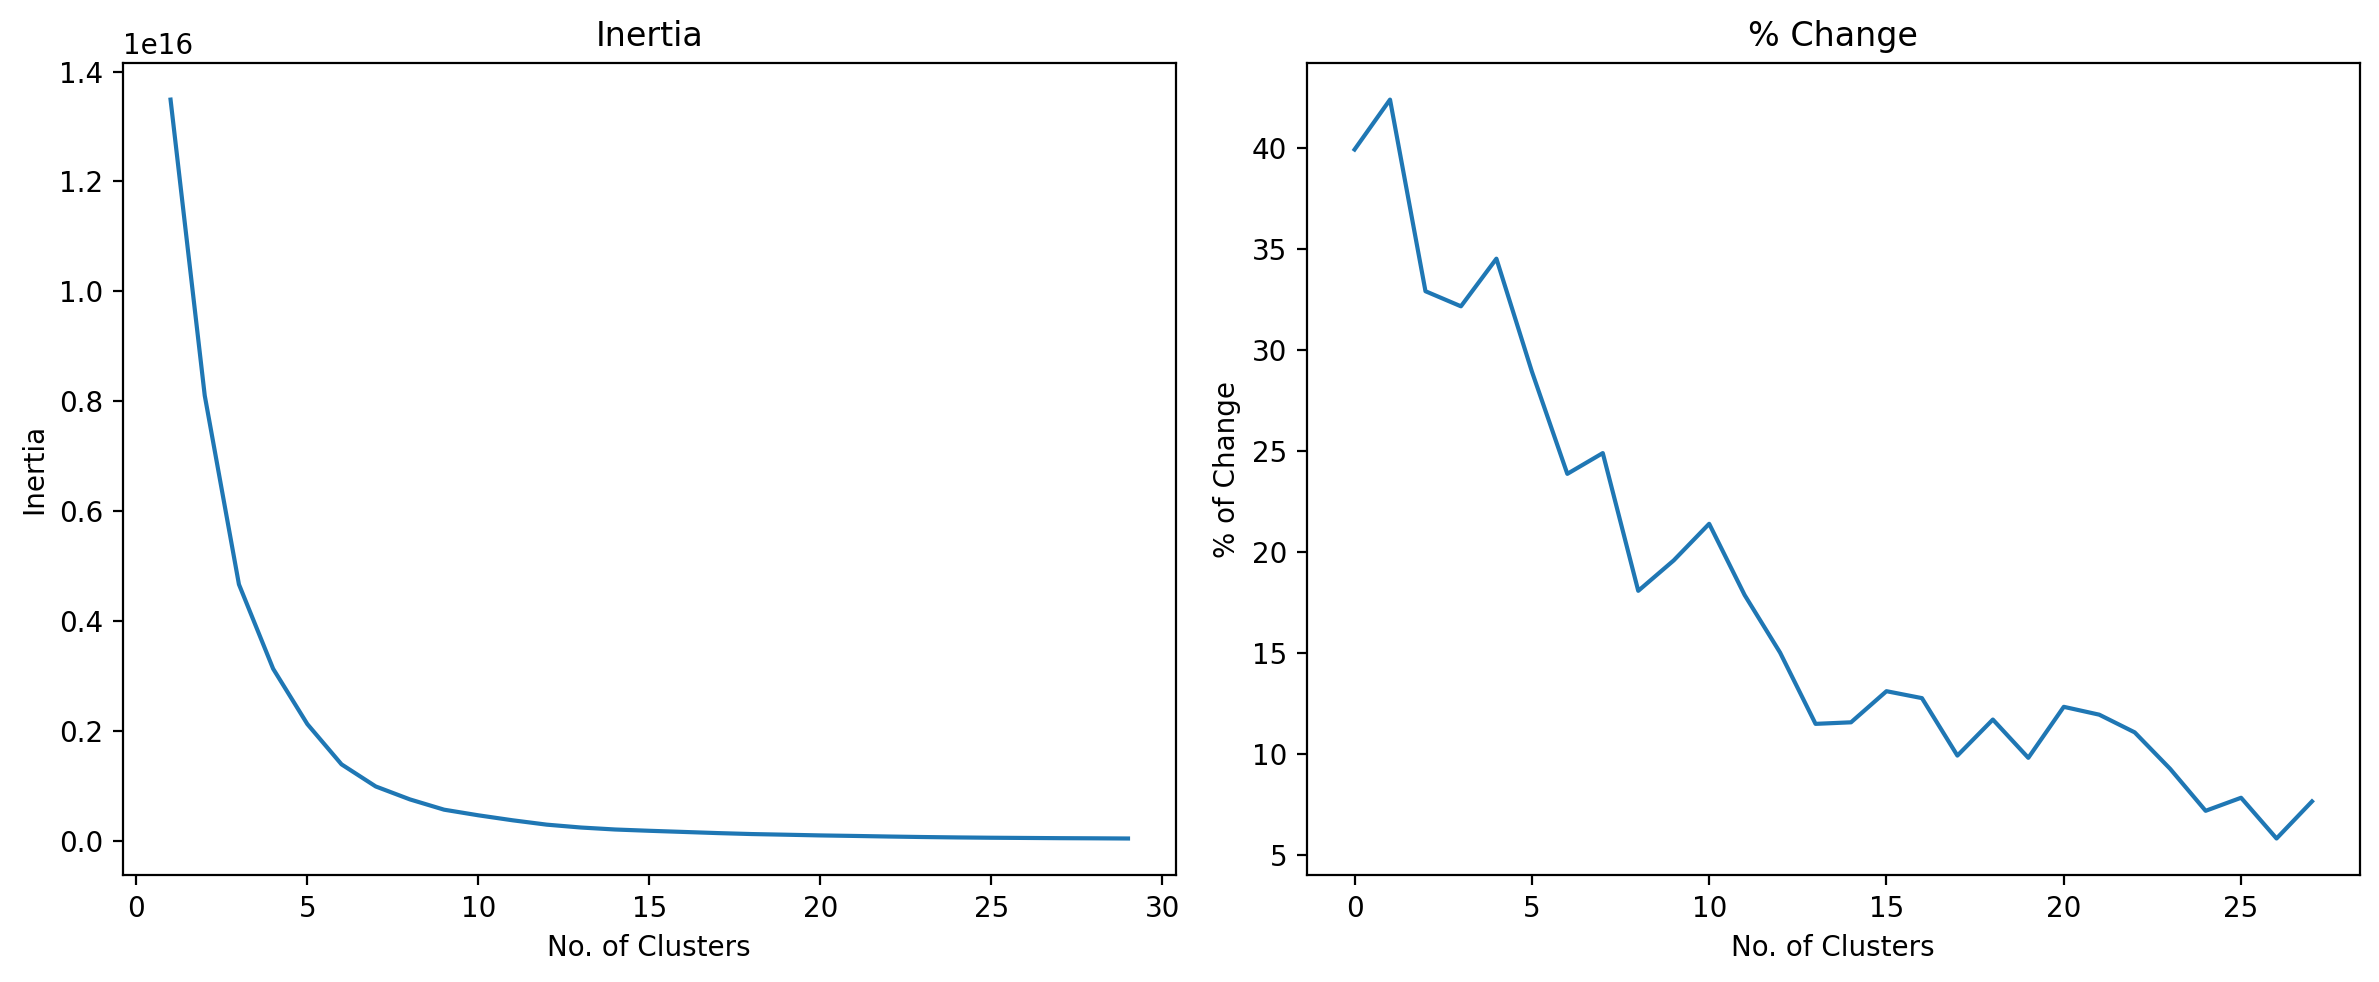

In [ ]:
e.generate_elbow(train[['tax_value','calc_sqft']])

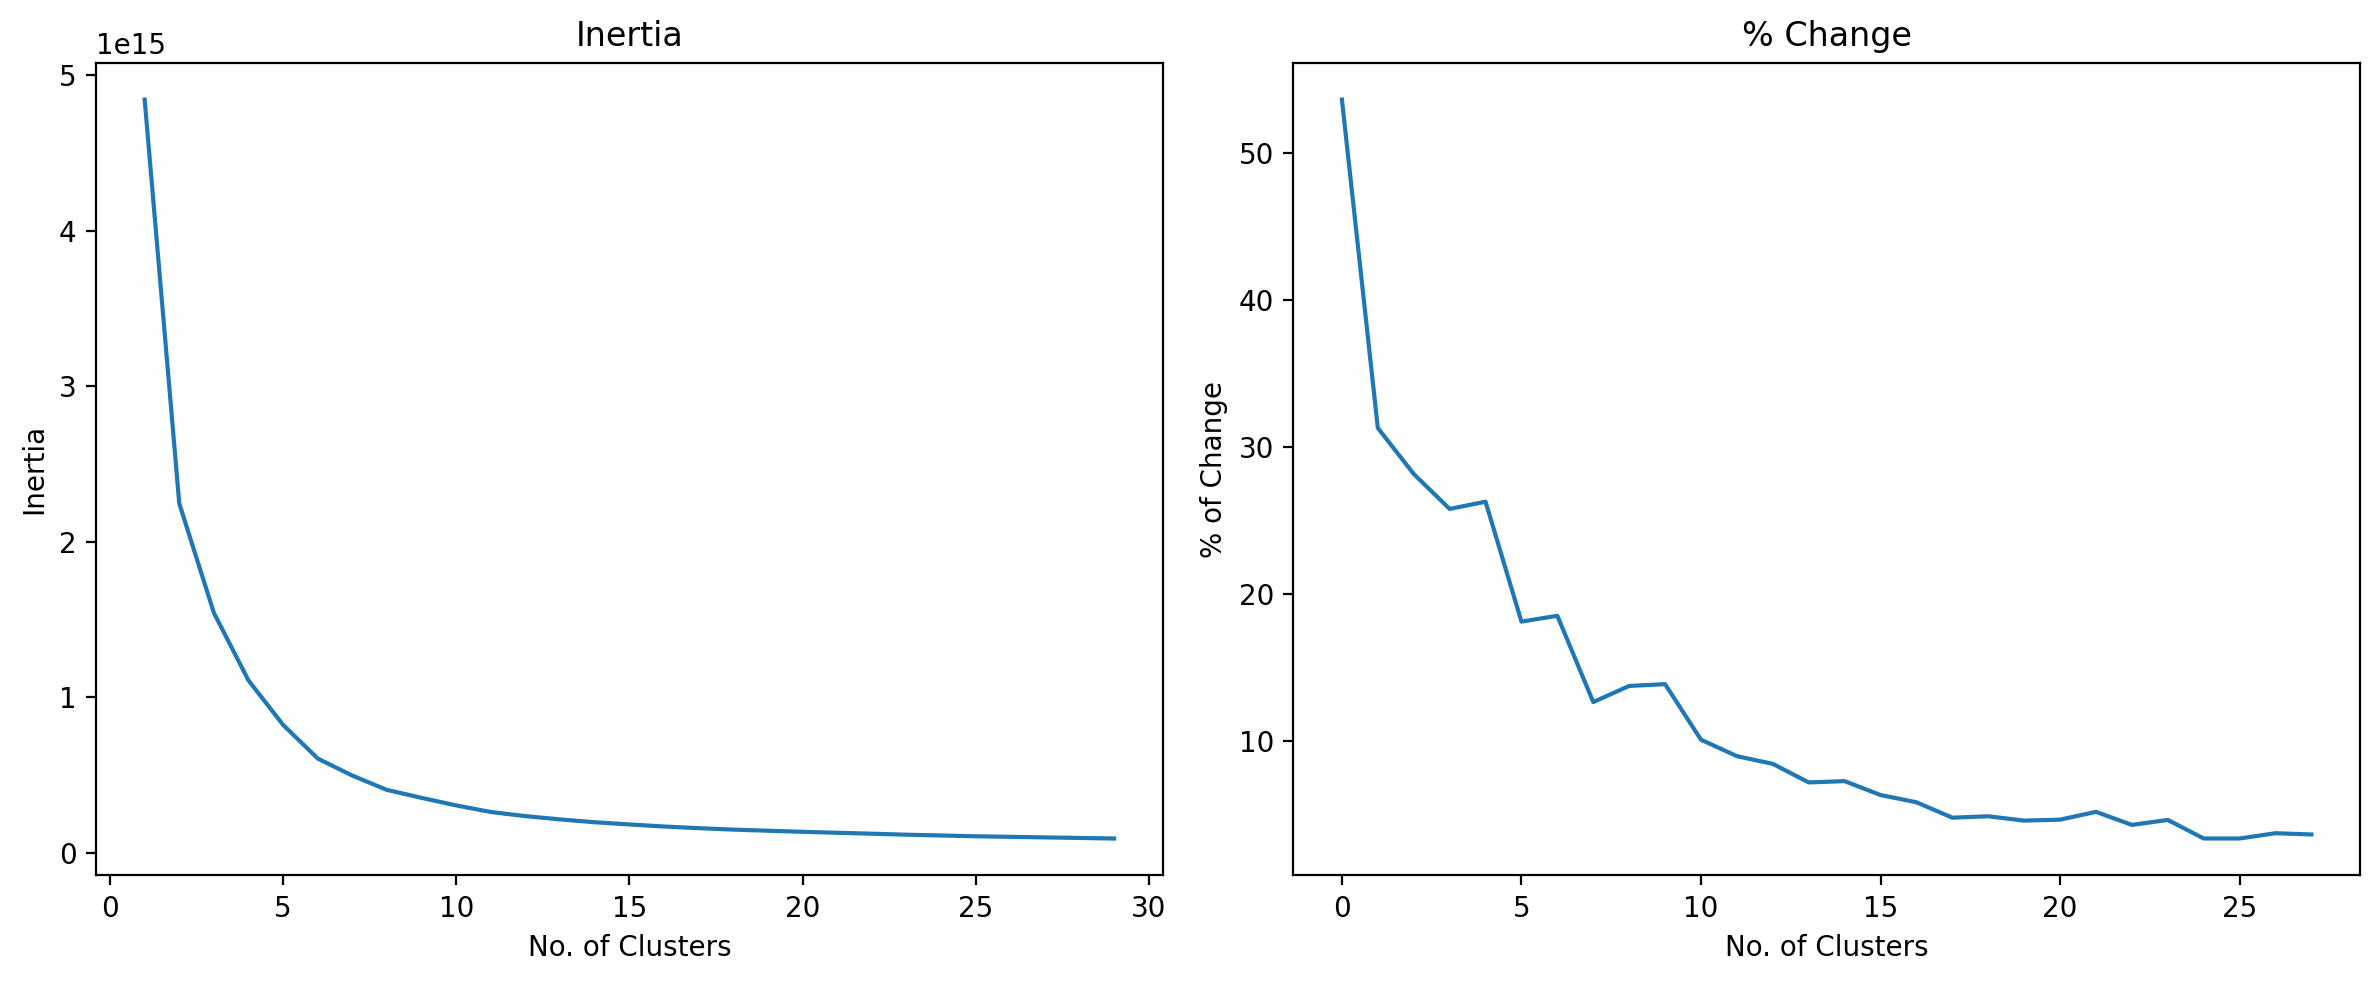

in       23845
above      257
below      101
Name: bound_group, dtype: int64

In [ ]:
reload(e)
tax_sqft = train[['calc_sqft','latitude','longitude']]
e.generate_elbow(tax_sqft,k_min=1,k_max=30)
train.bound_group.value_counts()

1    20354
0     3548
3      288
2       13
Name: tax_sqft_cluster, dtype: int64

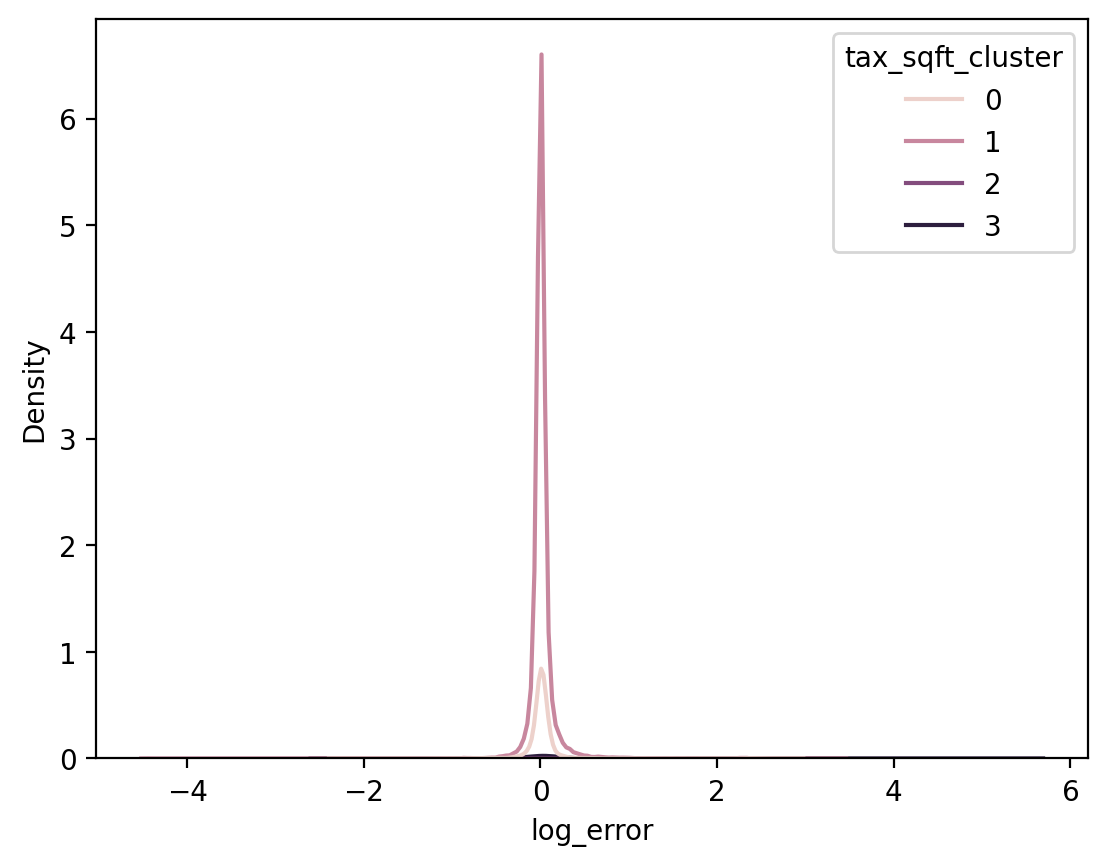

In [ ]:
tax_sqft = train[['calc_sqft','tax_value']]
tax_sqft['calc_sqft'] = train['calc_sqft']
tax_sqft['tax_value'] = train['tax_value']
kmeans = KMeans(4,random_state=420)
kmeans.fit(tax_sqft)
tax_sqft['tax_sqft_cluster'] = kmeans.predict(tax_sqft)
tax_sqft['log_error'] = train.log_error
sns.kdeplot(data=tax_sqft, x='log_error',hue='tax_sqft_cluster',common_grid=False)
tax_sqft.tax_sqft_cluster.value_counts()

Question: is the mean log_error of items clustered by tax_value and calc_sqft significantly different from each other?
$H_0$: $\mu_{taxsqft0} = \mu_{taxsqft1}=$...$\mu_{taxsqft7}$

$H_a$: $\mu_{taxsqft0} \neq \mu_{taxsqft1} \neq $...$\neq \mu_{taxsqft7}$

## Assumptions
- Independent: Yep
- Normal: yes, Central Limit Theorum
- Equal variance:

In [ ]:
train['tax_sqft_cluster'] = tax_sqft.tax_sqft_cluster
train.groupby('tax_sqft_cluster').agg('var').log_error

tax_sqft_cluster
0    0.036410
1    0.025402
2    0.299697
3    0.195313
Name: log_error, dtype: float64

## Nope! so we will use the non-parametric test

In [ ]:
group_list = [train[train.tax_sqft_cluster == x].log_error.to_numpy() for x in range(4)]
t,p = stats.kruskal(group_list[0],group_list[1],group_list[2],group_list[3])
e.t_to_md(t,p)

## t = 7.53317935249534e-08 

 ## p = 35.98774688175805 

## Because t > 0 and $\alpha$ < p,we failed to  reject $H_0$